In [ ]:
import torch
import os
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import import_ipynb
import gibbs_sampler_poise
import kl_divergence_calculator
import data_preprocessing
from torchvision.utils import save_image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.nn import functional as F  #for the activation function
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torchvision
import umap
import random
import shutil

importing Jupyter notebook from gibbs_sampler_poise.ipynb
importing Jupyter notebook from kl_divergence_calculator.ipynb
importing Jupyter notebook from data_preprocessing.ipynb


In [2]:
# learning parameters
latent_dim1 = 32
latent_dim2 = 16
batch_size = 10
dim_MNIST   = 784
lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tx = transforms.ToTensor()
MNIST_TRAINING_PATH = "/home/achint/Practice_code/VAE/MNIST/MNIST/processed/training.pt"
SVHN_TRAINING_PATH  = "/home/achint/Practice_code/VAE/SVHN/train_32x32.mat"
MNIST_TEST_PATH     = "/home/achint/Practice_code/VAE/MNIST/MNIST/processed/test.pt"
SVHN_TEST_PATH  = "/home/achint/Practice_code/VAE/SVHN/test_32x32.mat"
SUMMARY_WRITER_PATH = "/home/achint/Practice_code/logs"
RECONSTRUCTION_PATH = "/home/achint/Practice_code/Synthetic_dataset/POISE_VAE_SVHN_MNIST/reconstructions/"
PATH = "/home/achint/Practice_code/Synthetic_dataset/POISE_VAE_SVHN_MNIST/untitled.txt"

In [3]:
# Remove the logs directory and the reconstruction directory 
if os.path.exists(RECONSTRUCTION_PATH):
    shutil.rmtree(RECONSTRUCTION_PATH)
    os.makedirs(RECONSTRUCTION_PATH)

if os.path.exists(SUMMARY_WRITER_PATH):
    shutil.rmtree(SUMMARY_WRITER_PATH)
    os.makedirs(SUMMARY_WRITER_PATH)

In [3]:
## Importing MNIST and SVHN datasets
joint_dataset_train=data_preprocessing.JointDataset(mnist_pt_path=MNIST_TRAINING_PATH,
                             svhn_mat_path=SVHN_TRAINING_PATH)
joint_dataset_test = data_preprocessing.JointDataset(mnist_pt_path=MNIST_TEST_PATH,
                             svhn_mat_path=SVHN_TEST_PATH)

joint_dataset_train_loader = DataLoader(
    joint_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
joint_dataset_test_loader = DataLoader(
    joint_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)


In [21]:
class VAE(nn.Module):
    def __init__(self,latent_dim1, latent_dim2, batch_size,use_mse_loss=True):
        super(VAE,self).__init__()
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2
        self.batch_size = batch_size
        self.use_mse_loss = use_mse_loss
        
        self.gibbs                   = gibbs_sampler_poise.gibbs_sampler(self.latent_dim1, self.latent_dim2, self.batch_size)  
        self.kl_div                  = kl_divergence_calculator.kl_divergence(self.latent_dim1, self.latent_dim2, self.batch_size)
        ## Encoder set1(MNIST)
        self.set1_enc1 = nn.Linear(in_features = dim_MNIST,out_features = 512)
        self.set1_enc2 = nn.Linear(in_features = 512,out_features = 128)
        self.set1_enc3 = nn.Linear(in_features = 128,out_features = 2*latent_dim1)
        
        ## Decoder set1(MNIST)
        self.set1_dec1 = nn.Linear(in_features = latent_dim1,out_features = 128)
        self.set1_dec2 = nn.Linear(in_features = 128,out_features = 512)
        self.set1_dec3 = nn.Linear(in_features = 512,out_features = dim_MNIST)
        
        ## Encoder set2(SVHN)
        # input size: 3 x 32 x 32
        self.set2_enc1 = nn.Conv2d(in_channels=3, out_channels=2*latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 32 x 16 x 16
        self.set2_enc2 = nn.Conv2d(in_channels=2*latent_dim2, out_channels=2*latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 32 x 8 x 8
        self.set2_enc3 = nn.Conv2d(in_channels=2*latent_dim2, out_channels=latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 16 x 4 x 4    

        ## Decoder set2(SVHN)
        # input size: 16x1x1
        self.set2_dec0 = nn.ConvTranspose2d(in_channels=latent_dim2,out_channels=latent_dim2, kernel_size=4, stride=1, padding=0)
        # input size: 16x4x4
        self.set2_dec1 = nn.ConvTranspose2d(in_channels=latent_dim2,out_channels=2*latent_dim2, kernel_size=3, stride=1, padding=1)
        # size: 32 x 4 x 4
        self.set2_dec2 = nn.ConvTranspose2d(in_channels=2*latent_dim2,out_channels=2*latent_dim2, kernel_size=5, stride=1, padding=0)
        # size: 32 x 8 x 8
        self.set2_dec3 = nn.ConvTranspose2d(in_channels=2*latent_dim2,out_channels=2*latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 32 x 16 x 16
        self.set2_dec4 = nn.ConvTranspose2d(in_channels=2*latent_dim2,out_channels=3, kernel_size=4, stride=2, padding=1)
        # size: 3 x 32 x 32
        
        self.SVHNc1 = nn.Conv2d(latent_dim2, latent_dim2, 4, 1, 0)
        # size: 16 x 1 x 1
        self.SVHNc2 = nn.Conv2d(latent_dim2, latent_dim2, 4, 1, 0)
        # size: 16 x 1 x 1
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.flag_initialize= 1
        self.g12= torch.zeros(latent_dim1,latent_dim2).to(device)
    def forward(self,x1,x2):
        data1    = x1 #MNIST
        data2    = x2 #SVHN
        # Modality 1 (MNIST)
        x1       = F.relu(self.set1_enc1(x1))
        x1       = F.relu(self.set1_enc2(x1))  
        x1       = self.set1_enc3(x1).view(-1,2,latent_dim1)  # ->[128,2,32]
        mu1      = x1[:,0,:] # ->[128,32]
        log_var1 = x1[:,1,:] # ->[128,32]
        var1     = -torch.exp(log_var1)           #lambdap_2<0
        # Modality 2 (SVHN)
        x2 = x2.view(-1,3, 32,32) 
        x2 = F.relu(self.set2_enc1(x2))
        x2 = F.relu(self.set2_enc2(x2))
        x2 = F.relu(self.set2_enc3(x2))
        # get 'mu' and 'log_var' for SVHN
        mu2 = (self.SVHNc1(x2).squeeze(3)).squeeze(2)
        log_var2 = (self.SVHNc2(x2).squeeze(3)).squeeze(2)
        var2 = -torch.exp(log_var2)       
        g22      = -torch.exp(self.g22)     
# Initializing gibbs sample        
        if self.flag_initialize==1:
            z1_prior,z2_prior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                        torch.zeros_like(mu1),
                                                        torch.zeros_like(mu2),
                                                        self.g11,
                                                        g22,
                                                        torch.zeros_like(mu1),
                                                        torch.zeros_like(var1),
                                                        torch.zeros_like(mu2),
                                                        torch.zeros_like(var2),
                                                        n_iterations=5000)
            z1_posterior,z2_posterior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                torch.zeros_like(mu1),
                                                                torch.zeros_like(mu2),
                                                                self.g11,
                                                                g22,
                                                                mu1, 
                                                                var1,
                                                                mu2,
                                                                var2,
                                                                n_iterations=5000)
            self.z1_prior        = z1_prior
            self.z2_prior        = z2_prior
            self.z1_posterior    = z1_posterior
            self.z2_posterior    = z2_posterior
            self.flag_initialize = 0
        z1_prior     = self.z1_prior.detach()
        z2_prior     = self.z2_prior.detach()
        z1_posterior = self.z1_posterior.detach()
        z2_posterior = self.z2_posterior.detach()
        self.z1_gibbs_prior,self.z2_gibbs_prior         = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                                  z1_prior,
                                                                                  z2_prior,
                                                                                  self.g11,
                                                                                  g22,
                                                                                  torch.zeros_like(mu1),
                                                                                  torch.zeros_like(var1),
                                                                                  torch.zeros_like(mu2),
                                                                                  torch.zeros_like(var2),
                                                                                  n_iterations=5)
        self.z1_gibbs_posterior,self.z2_gibbs_posterior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                                  z1_posterior,
                                                                                  z2_posterior,
                                                                                  self.g11,
                                                                                  g22,
                                                                                  mu1,
                                                                                  var1,
                                                                                  mu2,
                                                                                  var2,
                                                                                  n_iterations=5)
        self.z1_posterior = self.z1_gibbs_posterior.detach()
        self.z2_posterior = self.z2_gibbs_posterior.detach()
        self.z1_prior = self.z1_gibbs_prior.detach()
        self.z2_prior = self.z2_gibbs_prior.detach()
        G1 = torch.cat((self.g11,self.g12),0)
        G2 = torch.cat((self.g12,g22),0)
        G  = torch.cat((G1,G2),1)
        
        self.z2_gibbs_posterior = self.z2_gibbs_posterior.unsqueeze(2)
        self.z2_gibbs_posterior = self.z2_gibbs_posterior.unsqueeze(3)

        # decoding for MNIST
        x1 = F.relu(self.set1_dec1(self.z1_gibbs_posterior))
        x1 = self.set1_dec2(x1)


        # decoding for SVHN
        x2 = F.relu(self.set2_dec0(self.z2_gibbs_posterior))
        x2 = F.relu(self.set2_dec1(x2))
        x2 = F.relu(self.set2_dec2(x2))
        x2 = F.relu(self.set2_dec3(x2))
        
        if self.use_mse_loss:
            reconstruction1 = self.set1_dec3(x1)
            reconstruction2 = (self.set2_dec4(x2)).view(-1,3072)
        else:
            reconstruction1 = torch.sigmoid(self.set1_dec3(x1))
            reconstruction2 = torch.sigmoid((self.set2_dec4(x2)).view(-1,3072))
        self.z2_gibbs_posterior = self.z2_gibbs_posterior.squeeze()

        # calculating loss
        part_fun0,part_fun1,part_fun2 = self.kl_div.calc(G,self.z1_gibbs_posterior,self.z2_gibbs_posterior,self.z1_gibbs_prior,self.z2_gibbs_prior,mu1,var1,mu2,var2)
        
        if self.use_mse_loss:
            mse_loss = nn.MSELoss(reduction='sum')
            MSE1 = mse_loss(reconstruction1, data1)
            MSE2 = mse_loss(reconstruction2, data2)
        else:
            bce_loss = nn.BCELoss(reduction='sum')
            MSE1 = bce_loss(reconstruction1, data1)
            MSE2 = bce_loss(reconstruction2, data2)
#         print(part_fun0,torch.sum(part_fun0))
#         print(part_fun1,torch.sum(part_fun1))
#         print(part_fun2,torch.sum(part_fun2))
#         print(MSE1,torch.sum(MSE1))
#         print(MSE2,torch.sum(MSE2))

        KLD  = part_fun0+part_fun1+part_fun2
        
        loss = MSE1+MSE2+KLD
        return self.z1_posterior,self.z2_posterior,reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss, MSE1, MSE2, KLD

In [30]:
state = torch.load(PATH)
model = VAE(latent_dim1, latent_dim2, batch_size,use_mse_loss=True).to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

for name, para in model.named_parameters():
    print(name)

g11
g22
set1_enc1.weight
set1_enc1.bias
set1_enc2.weight
set1_enc2.bias
set1_enc3.weight
set1_enc3.bias
set1_dec1.weight
set1_dec1.bias
set1_dec2.weight
set1_dec2.bias
set1_dec3.weight
set1_dec3.bias
set2_enc1.weight
set2_enc1.bias
set2_enc2.weight
set2_enc2.bias
set2_enc3.weight
set2_enc3.bias
set2_dec0.weight
set2_dec0.bias
set2_dec1.weight
set2_dec1.bias
set2_dec2.weight
set2_dec2.bias
set2_dec3.weight
set2_dec3.bias
set2_dec4.weight
set2_dec4.bias
SVHNc1.weight
SVHNc1.bias
SVHNc2.weight
SVHNc2.bias


In [31]:
def train(model,joint_dataloader,epoch):
    model.train()
    running_loss = 0.0
    running_mse1 = 0.0
    running_mse2 = 0.0
    running_kld  = 0.0
    running_loss = 0.0
    for i,joint_data in enumerate(joint_dataloader):
        data1    = joint_data[0]
        data1    = data1.float()
        data2   = joint_data[1]
        data2   = data2.float()
        data1    = data1.to(device)
        data2   = data2.to(device)
        data1    = data1.view(data1.size(0), -1)
        data2   = data2.view(data2.size(0), -1)
        optimizer.zero_grad()
        z1_posterior,z2_posterior,reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss, MSE1, MSE2, KLD       = model(data1,data2) 
        running_mse1 += MSE1.item()
        running_mse2 += MSE2.item()
        running_kld  += KLD.item()
        running_loss += loss.item()          #.item converts tensor with one element to number
        loss.backward()                      #.backward
        optimizer.step()                     #.step one learning step
    train_loss = running_loss/(len(joint_dataloader.dataset))
    mse1_loss = running_mse1 / (len(joint_dataloader.dataset))
    mse2_loss = running_mse2 / (len(joint_dataloader.dataset))
    kld_loss = running_kld / (len(joint_dataloader.dataset))
#     for name, param in model.named_parameters():
#         writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch)
    writer.add_scalar("training/loss", train_loss, epoch)
    writer.add_scalar("training/MSE1", mse1_loss, epoch)
    writer.add_scalar("training/MSE2", mse2_loss, epoch)
    writer.add_scalar("training/KLD", kld_loss, epoch)    
    return train_loss
    
def test(model,joint_dataloader,epoch):
    latent_repMNIST= []
    latent_repSVHN= []
    label_mnist= []
    label_svhn= []
    model.eval()
    running_loss = 0.0
    running_mse1 = 0.0
    running_mse2 = 0.0
    running_kld  = 0.0
    running_loss = 0.0
    with torch.no_grad():
        for i,joint_data in enumerate(joint_dataloader):
            data1   = joint_data[0]
            data1   = data1.float()

            data2  =joint_data[1]
            data2 = data2.float()

            label1  =joint_data[2]
            label2  =joint_data[3]
            
            data1 = data1.to(device)
            data2 = data2.to(device)
            data1 = data1.view(data1.size(0), -1)
            data2 = data2.view(data2.size(0), -1)
            
            z1_posterior,z2_posterior,reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss, MSE1, MSE2, KLD = model(data1,data2)  
            
            running_loss += loss.item()
            running_mse1 += MSE1.item()
            running_mse2 += MSE2.item()
            running_kld  += KLD.item()    
            
            latent_repMNIST.append(z1_posterior)
            latent_repSVHN.append(z2_posterior)
            label_mnist.append(label1)
            label_svhn.append(label2)

            #save the last batch input and output of every epoch
            if i == int(len(joint_dataloader.dataset)/joint_dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data1.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction1.view(batch_size, 1, 28, 28)[:8]))
                bothp = torch.cat((data2.view(batch_size, 3, 32, 32)[:8], 
                                  reconstruction2.view(batch_size, 3, 32, 32)[:8]))
                save_image(both.cpu(), os.path.join(RECONSTRUCTION_PATH, f"1_outputMNIST_{epoch}.png"), nrow=num_rows)
                save_image(bothp.cpu(), os.path.join(RECONSTRUCTION_PATH, f"1_outputSVHN_{epoch}.png"), nrow=num_rows)
    test_loss = running_loss/(len(joint_dataloader.dataset))
    mse1_loss = running_mse1 / (len(joint_dataloader.dataset))
    mse2_loss = running_mse2 / (len(joint_dataloader.dataset))
    kld_loss = running_kld / (len(joint_dataloader.dataset))
    writer.add_scalar("validation/loss", test_loss, epoch)
    writer.add_scalar("validation/MSE1", mse1_loss, epoch)
    writer.add_scalar("validation/MSE2", mse2_loss, epoch)
    writer.add_scalar("validation/KLD", kld_loss, epoch)
    latent_repMNIST = torch.vstack(latent_repMNIST).cpu().numpy()
    latent_repSVHN  = torch.vstack(latent_repSVHN).cpu().numpy()
    label_mnist     = torch.hstack(label_mnist).cpu().numpy()
    label_svhn      = torch.hstack(label_svhn).cpu().numpy()
    return test_loss,latent_repMNIST,latent_repSVHN,label_mnist,label_svhn

In [32]:
train_loss = []
test_loss = []
epochs = 5
writer=SummaryWriter(SUMMARY_WRITER_PATH)
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,joint_dataset_train_loader,epoch)
    test_epoch_loss,latent_repMNIST,latent_repSVHN,label_mnist,label_svhn = test(model,joint_dataset_test_loader,epoch)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)     
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Test Loss: {test_epoch_loss:.4f}")

Epoch 1 of 5
Train Loss: 45.9761
Test Loss: 46.5396
Epoch 2 of 5
Train Loss: 46.2844
Test Loss: 45.9425
Epoch 3 of 5
Train Loss: 45.8865
Test Loss: 46.8797
Epoch 4 of 5
Train Loss: 45.8955
Test Loss: 46.2658
Epoch 5 of 5
Train Loss: 45.9581
Test Loss: 46.1901


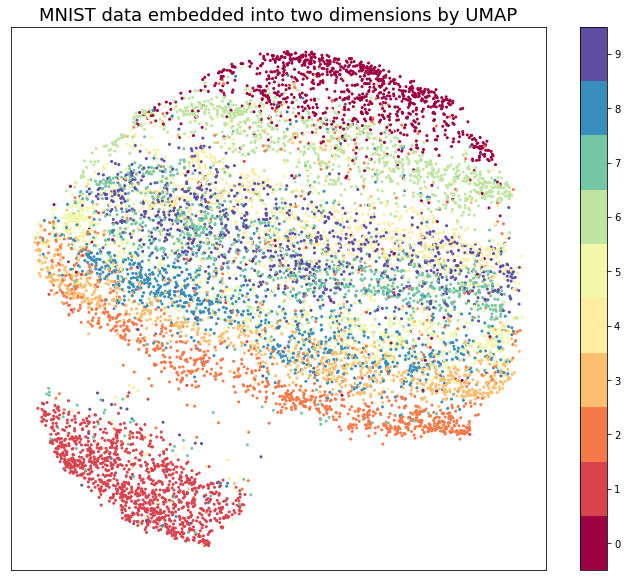

In [9]:
reducer   = umap.UMAP()
data      = latent_repMNIST   ## stores posterior samples (10000x32 datapoints)
color     = label_mnist       ## stores corresponding labels (10000, labels)
embedding = reducer.fit_transform(data)
fig, ax   = plt.subplots(1,figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1],c=color, cmap="Spectral", s=4)
plt.setp(ax, xticks=[], yticks=[])
cbar      = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(np.arange(10))
plt.title("MNIST data embedded into two dimensions by UMAP", fontsize=18)
ax.set_facecolor('white')
plt.show()    

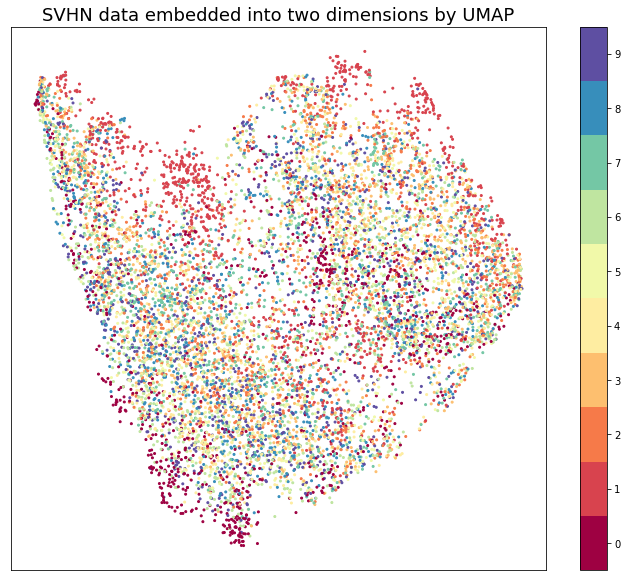

In [10]:
reducer = umap.UMAP()
data=latent_repSVHN
color = label_svhn
#labels=list(svhn_val_loader.dataset.labels.numpy())
embedding = reducer.fit_transform(data)
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1],c=color, cmap="Spectral", s=4)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(labels)
cbar.set_ticklabels(np.arange(10))

plt.title("SVHN data embedded into two dimensions by UMAP", fontsize=18)
ax.set_facecolor('white')

plt.show()

In [11]:
torch.save(model.state_dict(),PATH)


In [18]:
model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [33]:
state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()}
torch.save(state, PATH)